In [1]:
import cv2
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from PIL import Image
import random
from tqdm import tqdm

In [7]:
# read merged_results.csv

merged_df = pd.read_csv('./../utils_csv/merged_results.csv')
file_names = pd.read_csv('./../utils_csv/file_names.csv')


In [5]:
# Supondo que você já tenha os DataFrames 'merged_df' e 'file_names'

# Colunas pelas quais você deseja fazer o merge
merge_columns = ['image_id']  # Substitua pelas colunas relevantes

# Realizar o merge
merged_result = pd.merge(merged_df, file_names, on=merge_columns, how='inner')

In [6]:
merged_result.head()

,image_id,angulo_rotacao,rotated_image,topo,base,esquerda,direita,npy_image,binary_image,splash_image,type
0,calf_id_1387_20210621_743_depth_0042,-13.636698,E:/rotacionados/rotated_calf_id_1387_20210621_...,107,357,234,734,E:/Dario_depth/depth/1300s/depth_cropped/calf_...,E:/Dario_depth/masks/1300s/binary/calf_id_1387...,splash_calf_id_1387_20210621_743_depth_0042.png,1300
1,calf_id_1387_20210621_743_depth_0057,-14.931417,E:/rotacionados/rotated_calf_id_1387_20210621_...,115,365,216,716,E:/Dario_depth/depth/1300s/depth_cropped/calf_...,E:/Dario_depth/masks/1300s/binary/calf_id_1387...,splash_calf_id_1387_20210621_743_depth_0057.png,1300
2,calf_id_1387_20210621_743_depth_0059,-11.768289,E:/rotacionados/rotated_calf_id_1387_20210621_...,112,362,217,717,E:/Dario_depth/depth/1300s/depth_cropped/calf_...,E:/Dario_depth/masks/1300s/binary/calf_id_1387...,splash_calf_id_1387_20210621_743_depth_0059.png,1300
3,calf_id_1387_20210621_743_depth_0061,-10.768145,E:/rotacionados/rotated_calf_id_1387_20210621_...,110,360,220,720,E:/Dario_depth/depth/1300s/depth_cropped/calf_...,E:/Dario_depth/masks/1300s/binary/calf_id_1387...,splash_calf_id_1387_20210621_743_depth_0061.png,1300
4,calf_id_1387_20210621_743_depth_0064,-17.230053,E:/rotacionados/rotated_calf_id_1387_20210621_...,120,370,221,721,E:/Dario_depth/depth/1300s/depth_cropped/calf_...,E:/Dario_depth/masks/1300s/binary/calf_id_1387...,splash_calf_id_1387_20210621_743_depth_0064.png,1300


In [11]:

def rotate_image(imagem, angulo):
    # Obter o centro da imagem
    altura, largura = imagem.shape[:2]
    centro = (largura / 2, altura / 2)

    # Obter a matriz de rotação
    matriz_rotacao = cv2.getRotationMatrix2D(centro, angulo, 1.0)

    # Rotacionar a imagem
    imagem_rotacionada = cv2.warpAffine(imagem, matriz_rotacao, (largura, altura))

    return imagem_rotacionada


def process_and_multiply_cut(row, output_folder, target_height, target_width):
    npy_path = row['npy_image']
    png_path = row['binary_image']
    output_path = f"{output_folder}/resultado_{row['image_id']}.npy"  # Substitua pelo caminho desejado
    # output_path = f"{output_folder}/arquivo.npy"  # Substitua pelo caminho desejado

    # Carregar as matrizes do arquivo .npy e do arquivo .png
    npy_matrix = np.load(npy_path)
    png_matrix = cv2.imread(png_path, cv2.IMREAD_GRAYSCALE)

    # Normalizar a imagem binária
    normalized_png_matrix = png_matrix / 255.0

    # Multiplicar as matrizes
    result_matrix = npy_matrix * normalized_png_matrix

    # Rotacionar a matriz resultante
    rotated_result = rotate_image(result_matrix, row['angulo_rotacao'])

    # Definir as coordenadas de corte
    topo = row['topo']
    base = row['base']
    esquerda = row['esquerda']
    direita = row['direita']

    # Recortar a matriz resultante
    cropped_result = rotated_result[topo:base, esquerda:direita]

    # Redimensionar a matriz resultante para a altura e largura desejadas
    cropped_result_resized = cv2.resize(cropped_result, (target_width, target_height))

    # Salvar o resultado em um arquivo .npy
    np.save(output_path, cropped_result_resized)


In [14]:
# Definir as colunas que você deseja usar
selected_columns = ['npy_image', 'binary_image', 'angulo_rotacao', 'topo', 'base', 'esquerda', 'direita', 'image_id']

# Filtrar as colunas selecionadas no DataFrame
selected_filenames = merged_result[selected_columns]

# Definir o número de núcleos a serem usados para a paralelização
num_cores = 4  # Por exemplo, use 4 núcleos

# Definir a pasta de saída, altura e largura desejadas
output_folder = 'D:/dados_tcc/npy_rotacionadas_cortadas'
target_height = 256  # Substitua pela altura desejada
target_width = 512  # Substitua pela largura desejada

batch_size = 100

# Calcular o número total de lotes
num_batches = (len(selected_filenames) + batch_size - 1) // batch_size

# Processar em paralelo em lotes de 100
for batch_idx in tqdm(range(num_batches), desc="Processing Batches", unit="batch"):
    batch_start = batch_idx * batch_size
    batch_end = min(batch_start + batch_size, len(selected_filenames))
    batch = selected_filenames.iloc[batch_start:batch_end]

    Parallel(n_jobs=num_cores)(
        delayed(process_and_multiply_cut)(row, output_folder, target_height, target_width) for _, row in batch.iterrows()
    )

Processing Batches:   0%|          | 0/707 [00:00<?, ?batch/s]

Processing Batches: 100%|██████████| 707/707 [10:05<00:00,  1.17batch/s]


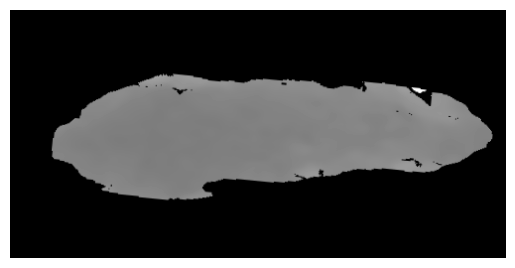

In [16]:
process_and_multiply_cut(merged_result.iloc[48900], "./", 250, 500)

import numpy as np
import matplotlib.pyplot as plt

# Carregar o arquivo .npy
npy_file_path = 'arquivo.npy'
npy_array = np.load(npy_file_path)

# Plotar a imagem
plt.imshow(npy_array, cmap='gray')  # Usando mapa de cores em escala de cinza
plt.axis('off')  # Desligar os eixos
plt.show()